In [1]:
import pandas as pd
import pickle
from tqdm import tqdm
from src.data.hex_utils import *

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from pyproj import Transformer
import datetime
from shapely.ops import unary_union

In [2]:
def get_hex_traj(traj, n_rows, limits):
    size = get_hex_size(limits, n_rows)
    xys = hex_to_coords(traj, size, limits[0])
    hexagons = [
        patches.RegularPolygon(
            xy,
            numVertices=6,
            radius=size,
            orientation=np.radians(30),
            edgecolor="k",
            facecolor=(0.1, 0.2, 0.8, 0.5),
            linewidth=0.5,
        )
        for xy in xys
    ]

    return hexagons

def coords_to_hex(coords: np.ndarray, hex_size: float, coord_offset: np.ndarray):
    """Converts geo-coordinates to axial hexgrid coordinates

    Parameters
    ----------
    coords : np.ndarray
        Coordinates of shape (n, 2) to convert to match to hexgrid.
    hex_size : float
        Size of hexagons.

    Returns
    -------
    Axial coordinates of form [q, r]
    """
    pixels = coords - coord_offset
    a = np.array([[2, -1], [0, np.sqrt(3)]]) / 3
    fracs = pixels @ a / hex_size
    return cell_round(fracs)

def hex_to_coords(hex, hex_size, coord_offset):
    a = np.array([[1.5, 0], [0.5 * np.sqrt(3), np.sqrt(3)]])
    return (hex_size * a @ hex.T).T + coord_offset


def create_hexagon(center, size):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]
    hexagon = Polygon(
        [
            (center[0] + size * np.cos(angle), center[1] + size * np.sin(angle))
            for angle in angles
        ]
    )
    return hexagon


def get_hexgrid(limits, n_rows=None, size=None):
    if size is None:
        size = get_hex_size(limits, n_rows)
    xstep = 3 / 2 * size
    ystep = np.sqrt(3) * size

    x = np.arange(limits[0][0], limits[1][0], xstep)
    y = np.arange(limits[0][1], limits[1][1], ystep)

    n_cols, n_rows = len(x), len(y)
    xs, ys = np.meshgrid(x, y)
    xy = np.stack([xs, ys], axis=-1)
    odd_cols = np.arange(1, n_cols, 2)
    xy[:, odd_cols, 1] += ystep / 2
    xy = xy.reshape(-1, 2)

    hexagons = [create_hexagon(center, size) for center in xy]
    qr = coords_to_hex(xy, size, coord_offset=limits[0])

    gdf = gpd.GeoDataFrame(data=qr, columns=['q', 'r'] ,geometry=hexagons)
    return gdf


In [38]:
def split_trajectories(df, distance_col='dist', threshold=200):
    # Create a new column to identify splits
    df['split'] = df[distance_col] > threshold
    
    # Create trajectory groups
    df['t_group'] = df.groupby('t_idx')['split'].cumsum()
    
    # Combine original trajectory_id with the new group
    df['t_idx'] = df.groupby(['t_idx', 't_group']).ngroup()
    
    # Drop intermediate columns
    df = df.drop(columns=['split', 't_group'])
    
    return df

In [75]:
crs1 = "epsg:4326"
crs2 = "epsg:3857"
limits = np.array([[116.1, 39.7], [116.7, 40.1]])
patch = np.array([[116.4, 39.9], [116.5, 39.95]])
max_date = datetime.datetime(2007, 9, 1)
n_rows = 100

transformer = Transformer.from_crs(crs1, crs2)

with open("../data/processed/geolife.pkl", "rb") as f:
    gdf = pickle.load(f)

gdf = gdf[(gdf["datetime"] < max_date) & (gdf['lat'])]
lon, lat = transformer.transform(gdf["lat"], gdf["lon"])
gdf["lon"] = lon
gdf["lat"] = lat
gdf = split_trajectories(gdf, threshold=2000)

lonlimit, latlimit = transformer.transform(limits[:, 1], limits[:, 0])
limits= np.array([lonlimit, latlimit]).T

lonpatch, latpatch = transformer.transform(patch[:, 1],patch[:, 0])
patch= np.array([lonpatch, latpatch]).T

hdf = hexagonize(gdf, n_rows=n_rows, limits=limits)
cells = hdf[['q', 'r']]
hdf['cell_dist'] = cell_distance(cells.values, cells.shift().values)
hdf['cell_dist'] = hdf['cell_dist'].fillna(1)
hdf = hdf[hdf['cell_dist'] >= 1]

In [76]:
# Create the hexagonal grid
size = get_hex_size(limits, n_rows)
grid = get_hexgrid(limits, size=size)
grid = grid.set_crs(crs2)
grid = grid.cx[patch[0, 0] : patch[1, 0], patch[0, 1] : patch[1, 1]]

# Get visit counts for each grid cell
n_cell_visits = hdf.groupby(["q", "r"]).size().reset_index()
n_cell_visits = n_cell_visits.rename(columns={0: "n_visits"})
grid = grid.merge(n_cell_visits, on=["q", "r"], how="left")
grid = grid.fillna(0)

# Get higher order coordinates
grid = grid.rename(columns={"q": "q0", "r": "r0"})
for level in tqdm(list(range(1, 4)), desc="Computing high-level cells..."):
    q_new, r_new = small_to_big(
        qr=grid[[f"q{level-1}", f"r{level-1}"]].values, radius=1
    ).T
    grid[f"q{level}"] = q_new
    grid[f"r{level}"] = r_new

Computing high-level cells...: 100%|██████████| 3/3 [00:00<00:00, 277.38it/s]


In [77]:
# Get number of visits for higher level cells
grids = [grid]
for level in list(range(1, 4)):
    result = (
        grid.groupby([f"q{level}", f"r{level}"])
        .agg({"geometry": unary_union, "n_visits": "sum"})
        .reset_index()
    )
    result = result.set_geometry("geometry")
    result = result.set_crs(crs2)
    grids.append(result)

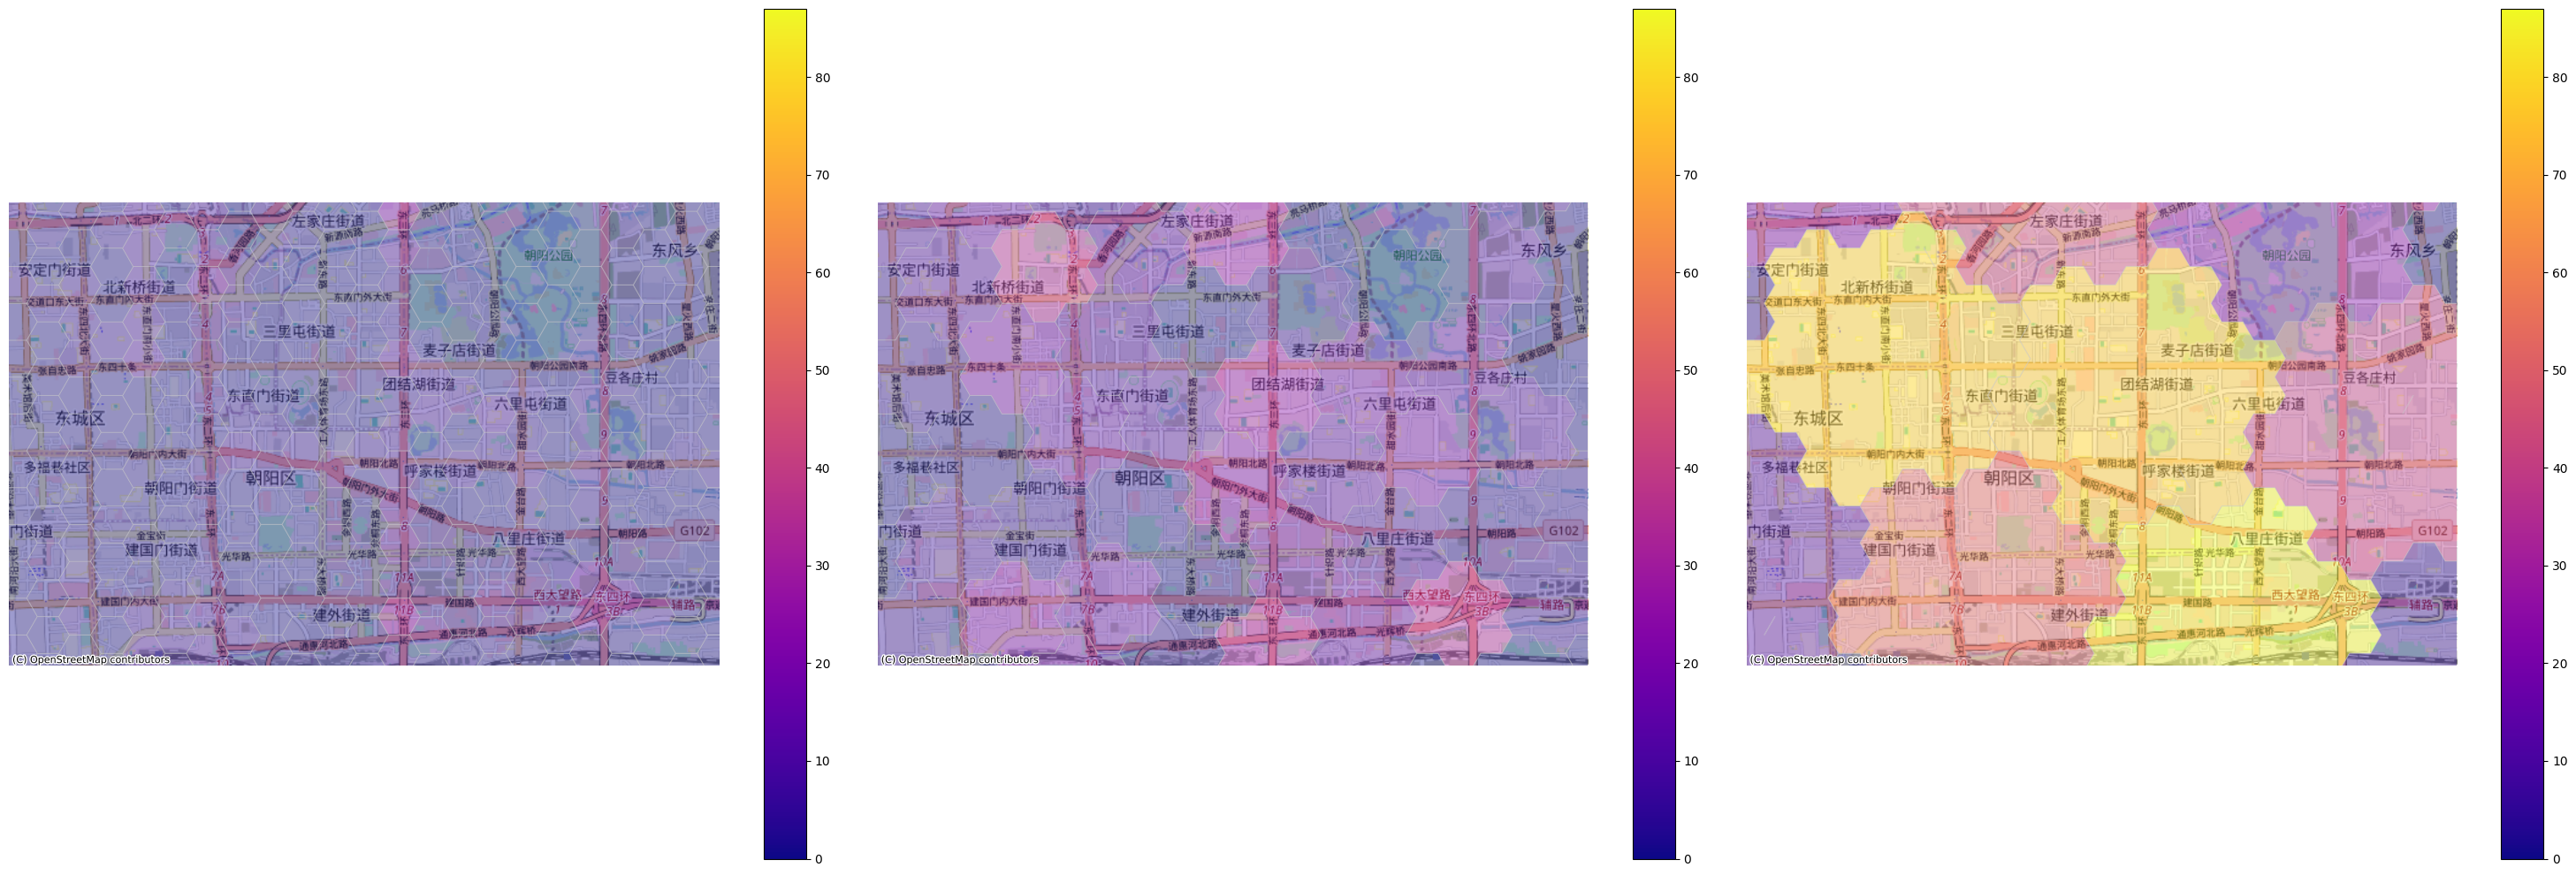

In [132]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
vmax_value = grids[-2]["n_visits"].max()
for i, hdfi in enumerate(grids[:-1]):
    # Ensure the GeoDataFrame is in Web Mercator projection
    hdfi = hdfi.to_crs(epsg=3857)
    ax = axs[i]
    hdfi.plot(
        column="n_visits",
        ax=ax,
        alpha=0.4,
        edgecolor="0.8",
        linewidth=0.8,
        legend=True,
        vmax=vmax_value,
        cmap='plasma',
    )
    # Add OpenStreetMap as background
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)
    # Remove axis
    ax.set_xlim(patch[0, 0], patch[1, 0]) 
    ax.set_ylim(patch[0, 1], patch[1, 1]) 
    ax.axis("off")
    ax.set_aspect("equal")


plt.tight_layout()
plt.savefig("heatmap.png", dpi=600)
# plt.savefig("heatmap.png")

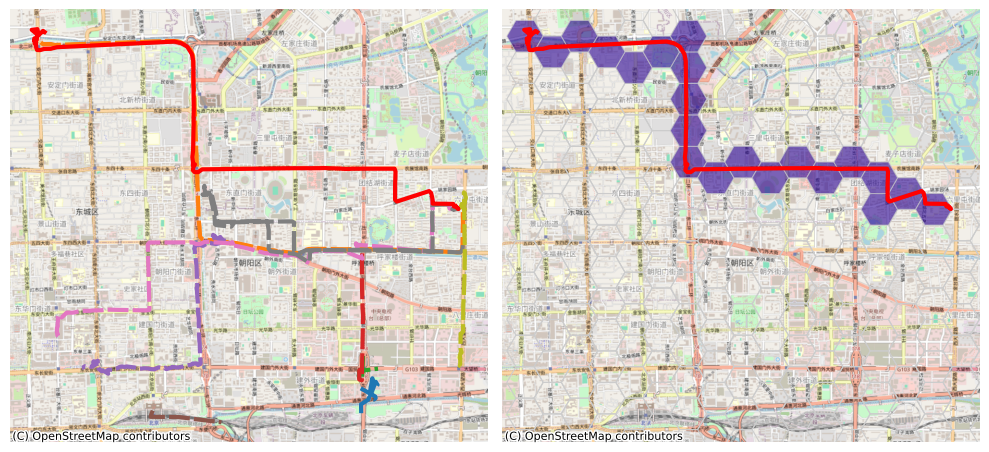

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axs[0]
df_patch = gdf[
    (patch[0, 0] <= gdf["lon"])
    & (gdf["lon"] <= patch[1, 0])
    & (gdf["lat"] >= patch[0, 1])
    & (gdf["lat"] <= patch[1, 1])
]

t_show = df_patch.groupby("t_idx")["dist"].sum().nlargest(10).index
df_patch = df_patch[df_patch["t_idx"].isin(t_show)]
color_unkown = "red"
color_known = None
idx_unkown = 564
# df_patch = gdf


for idx, tdf in df_patch.groupby("t_idx"):
    # Plot the line on the transformed coordinates
    color = color_unkown if idx == idx_unkown else color_known
    ax.plot(
        tdf["lon"],
        tdf["lat"],
        markersize=0,
        color=color,
        linewidth=3,
        linestyle="-" if idx == idx_unkown else (0, (5, 1)),
        zorder=10 if idx == idx_unkown else 5,
    )


# Add the OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)


tdf = df_patch[df_patch["t_idx"] == idx_unkown]
htdf = hexagonize(tdf, n_rows, limits)
htdf = interpolate_cell_jumps(htdf)
htdf = htdf.rename(columns={"q": "q0", "r": "r0"})
htdf['visited'] = 1
tgrid = grid.merge(htdf, on=['q0', 'r0'], how='left')
tgrid = tgrid.fillna(0)
tgrid[tgrid['visited'] == 0].plot(
  ax=axs[1],
        alpha=1.0,
        edgecolor="0.8",
        linewidth=0.8,
        facecolor="none",
)

tgrid[tgrid['visited'] == 1].plot(
  ax=axs[1],
        alpha=0.6,
        edgecolor="0.8",
        linewidth=0.8,
        facecolor="#2B0494",
)
axs[1].plot(
        tdf["lon"],
        tdf["lat"],
        markersize=0,
        color='red',
        linewidth=3,
        linestyle="-",
    )


ax.set_aspect("equal")
# ax.autoscale_view()
axs[0].axis("off")
axs[1].axis("off")
plt.tight_layout()
plt.savefig("traj.png", dpi=600)